# 01 — Data Exploration and Understanding

This notebook explores the County Health Rankings (CHR) datasets (2015–2025) used for both predictor and target construction as well as the hate crime (FBI) dataset (2015-2025) used for target construction.
I summarized key variables, check for completeness, and validate the population-weighted aggregation logic.


## 1. Dataset Overview

The County Health Rankings (CHR) dataset is published annually by the University of Wisconsin Population Health Institute.
Each year's release includes hundreds of county-level indicators on health outcomes, behaviors, social factors, and environmental quality.

The hate crime dataset is updated annually by the FBI and uncludes types of hate crime, affected number of people and year of occurrence among other factors.

For this project:
- **Years used:** 2015–2025  
- **Level:** County → aggregated to **State** via population-weighted averages  
- **Format:** `analytic_data{YEAR}.csv`, `hate_crime.csv`

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, json

DATA_DIR = "../data"
YEARS = range(2015, 2026)

sample_year = 2025
df = pd.read_csv(f"{DATA_DIR}/analytic_data{sample_year}.csv")
df.head()

,statecode,countycode,fipscode,state,county,year,county_clustered,v001_rawvalue,v001_numerator,v001_denominator,...,v058_rawvalue,v058_numerator,v058_denominator,v058_cilow,v058_cihigh,v051_rawvalue,v051_numerator,v051_denominator,v051_cilow,v051_cihigh
0,0,0,0,US,United States,2025,NaN,8351.736549,4763989.0,925367214.0,...,0.200031,66300254.0,331449281.0,NaN,NaN,334914895.0,NaN,NaN,NaN,NaN
1,1,0,1000,AL,Alabama,2025,NaN,11853.247250,102760.0,13958454.0,...,0.422628,2123399.0,5024279.0,NaN,NaN,5108468.0,NaN,NaN,NaN,NaN
2,1,1,1001,AL,Autauga County,2025,1.0,9938.263382,1008.0,163064.0,...,0.406768,23920.0,58805.0,NaN,NaN,60342.0,NaN,NaN,NaN,NaN
3,1,3,1003,AL,Baldwin County,2025,1.0,8957.112686,3944.0,653515.0,...,0.375865,87113.0,231767.0,NaN,NaN,253507.0,NaN,NaN,NaN,NaN
4,1,5,1005,AL,Barbour County,2025,1.0,12738.656140,587.0,67912.0,...,0.659200,16627.0,25223.0,NaN,NaN,24585.0,NaN,NaN,NaN,NaN


In [8]:
df_hate = pd.read_csv(f"{DATA_DIR}/hate_crime.csv")
df_hate.head()

,incident_id,data_year,ori,pug_agency_name,pub_agency_unit,agency_type_name,state_abbr,state_name,division_name,region_name,...,offender_race,offender_ethnicity,victim_count,offense_name,total_individual_victims,location_name,bias_desc,victim_types,multiple_offense,multiple_bias
0,43,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,Not Specified,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S
1,44,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,Not Specified,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,M,S
2,45,1991,AR0600300,North Little Rock,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,Not Specified,2,Aggravated Assault;Murder and Nonnegligent Man...,2.0,Residence/Home,Anti-White,Individual,M,S
3,46,1991,AR0600300,North Little Rock,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,Not Specified,1,Intimidation,1.0,Residence/Home,Anti-White,Individual,S,S
4,47,1991,AR0670000,Sevier,NaN,County,AR,Arkansas,West South Central,South,...,White,Not Specified,1,Intimidation,1.0,School/College,Anti-Black or African American,Individual,S,S


## 2. County Health Rankings Variable Dictionary

Below are the CHR variable codes and descriptions used in this project.  
Each variable appears in the annual CHR analytic data files.

In [ ]:
# --- Target variables ---
target_dict = {
    # Health outcomes
    "v001_rawvalue": "Premature death per 100,000",
    "v127_rawvalue": "Premature age-adjusted mortality",
    "v128_rawvalue": "Child mortality",
    "v129_rawvalue": "Infant mortality",
    "v135_rawvalue": "Injury deaths",
    "v161_rawvalue": "Suicides",
    "v015_rawvalue": "Homicides",
    "v039_rawvalue": "Motor vehicle crash deaths",
    "v148_rawvalue": "Firearm fatalities",

    # Environmental / infrastructure factors
    "v125_rawvalue": "Air pollution (PM2.5)",
    "v124_rawvalue": "Drinking water violations",
    "v179_rawvalue": "Access to parks",
    "v182_rawvalue": "Adverse climate events",
    "v166_rawvalue": "Broadband access",
    "v181_rawvalue": "Library access",
    "v156_rawvalue": "Traffic volume",

    # Behavioral / social outcomes
    "v134_rawvalue": "Alcohol-impaired driving deaths",
    "v139_rawvalue": "Food insecurity",
    "v083_rawvalue": "Limited access to healthy foods",
    "v133_rawvalue": "Food environment index",
    "v155_rawvalue": "Flu vaccination"
}

# --- Predictor variables ---
predictor_dict = {
    # Health behaviors
    "v009_rawvalue": "Adult smoking",
    "v011_rawvalue": "Adult obesity",
    "v049_rawvalue": "Excessive drinking",
    "v070_rawvalue": "Physical inactivity",
    "v045_rawvalue": "Sexually transmitted infections",
    "v014_rawvalue": "Teen births",
    "v138_rawvalue": "Drug overdose deaths",
    "v060_rawvalue": "Diabetes prevalence",
    "v061_rawvalue": "HIV prevalence",
    "v132_rawvalue": "Access to exercise opportunities",
    "v183_rawvalue": "Feelings of loneliness",
    "v143_rawvalue": "Insufficient sleep",

    # Clinical care
    "v004_rawvalue": "Ratio of population to primary care physicians",
    "v062_rawvalue": "Ratio of population to mental health providers",
    "v088_rawvalue": "Ratio of population to dentists",
    "v005_rawvalue": "Preventable hospital stays",
    "v085_rawvalue": "Uninsured",
    "v131_rawvalue": "Ratio of population to other primary care providers",

    # Social & economic factors
    "v024_rawvalue": "Children in poverty",
    "v044_rawvalue": "Income inequality",
    "v069_rawvalue": "Some college education",
    "v168_rawvalue": "High school completion",
    "v023_rawvalue": "Unemployment",
    "v140_rawvalue": "Social associations",
    "v171_rawvalue": "Child care cost burden",
    "v151_rawvalue": "Gender pay gap",
    "v063_rawvalue": "Median household income",
    "v170_rawvalue": "Living wage",
    "v172_rawvalue": "Child care centers",
    "v141_rawvalue": "Residential segregation (Black/White)",
    "v149_rawvalue": "Disconnected youth",
    "v184_rawvalue": "Lack of social and emotional support",
    "v177_rawvalue": "Voter turnout",

    # Physical environment & housing
    "v136_rawvalue": "Severe housing problems",
    "v153_rawvalue": "Home ownership",
    "v154_rawvalue": "Severe housing cost burden",
    "v067_rawvalue": "Driving alone to work",
    "v137_rawvalue": "Long commute",

    # Education & community context
    "v167_rawvalue": "School segregation",
    "v169_rawvalue": "School funding adequacy",

    # Health outcomes (as predictive indicators)
    "v036_rawvalue": "Poor physical health days",
    "v042_rawvalue": "Poor mental health days",
    "v144_rawvalue": "Frequent physical distress",
    "v145_rawvalue": "Frequent mental distress",
    "v147_rawvalue": "Life expectancy"
}

print("Target Metrics:", json.dumps(target_dict, indent=2))
print("\nPredictor Metrics:", json.dumps(predictor_dict, indent=2))

## 2. Hate Crime Variable Dictionary

Below are the hate crime variable codes and descriptions used in this project.  
Each variable appears in the hate crime data file.

In [ ]:
hate_metric_dict = {
    "state_name": "State name",
    "data_year": "Year of occurrence",
    "incident_id": "hate crime event count"
}

print("Hate Metrics Dictionary:", json.dumps(hate_metric_dict, indent=2))

## 3. Explore Variable Coverage

Aim to demonstrate check for missingness and numeric distributions for a sample year (2025).

In [ ]:
# --- Explore variable coverage for CHR dataset---
cols = list(target_dict.keys()) + list(predictor_dict.keys())
subset = df[["state"] + [c for c in cols if c in df.columns]]
subset.isna().mean().sort_values(ascending=False).head(15)

In [ ]:
# --- Explore variable coverage for Hate Crime dataset---
cols_hate = list(hate_metric_dict.keys())
subset_hate = df_hate[["state_name"] + [c for c in cols_hate if c in df_hate.columns]]
subset_hate.isna().mean().sort_values(ascending=False).head(15)

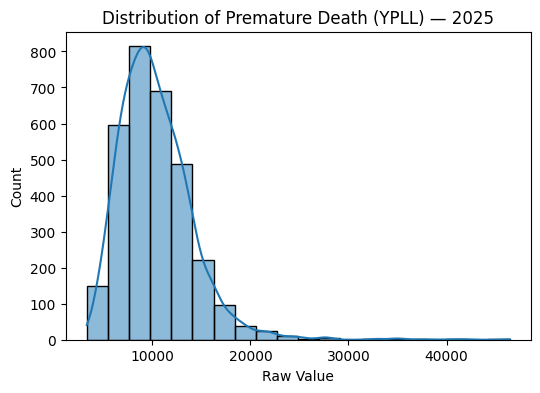

In [23]:
# --- Plot distributions of a few sample variables for CHR ---
plt.figure(figsize=(6,4))
sns.histplot(df["v001_rawvalue"], bins=20, kde=True)
plt.title("Distribution of Premature Death (YPLL) — 2025")
plt.xlabel("Raw Value")
plt.show()

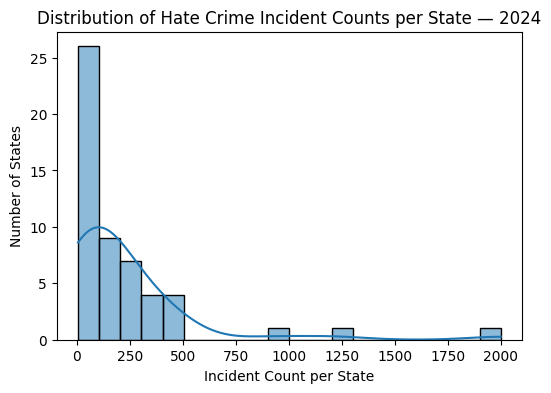

In [27]:
# --- Plot distributions of a few sample variables for hate crime ---
# Aggregate number of incidents per state for 2024
df_2024 = df_hate[df_hate["data_year"] == 2024]
state_counts = df_2024.groupby("state_name")["incident_id"].count()

# Plot distribution of state-level counts
plt.figure(figsize=(6, 4))
sns.histplot(state_counts, bins=20, kde=True)
plt.title("Distribution of Hate Crime Incident Counts per State — 2024")
plt.xlabel("Incident Count per State")
plt.ylabel("Number of States")
plt.show()

## 4. Validate Population-Weighted Aggregation Logic
Each CHR file contains denominators (e.g., population, sample size).  
Showing that population-weighted means at the county level reproduce state averages accurately.

In [ ]:
# --- Validate Population-Weighted Aggregation Logic ---
# v001_rawvalue: Premature death per 100,000
df["weighted_value"] = df["v001_rawvalue"] * df["v001_denominator"]
agg = df.groupby("state").apply(lambda g: g["weighted_value"].sum() / g["v001_denominator"].sum())
agg.head()

## 5. Cross-Year Availability for CHR

Demonstrating target/predictor metric distribution across the selected 10 years.
Some metrics were not tracked for all 10 years. And additional metrics are added yearly. Not all metrics in the dataset are tracked for this project.
Not relevant for hate crime.

In [29]:
# --- Cross-Year Availability for CHR ---
availability = {}
for year in YEARS:
    f = f"{DATA_DIR}/analytic_data{year}.csv"
    if not os.path.exists(f):
        continue
    df_y = pd.read_csv(f, nrows=1)
    available = [v for v in cols if v in df_y.columns]
    availability[year] = len(available)

pd.DataFrame.from_dict(availability, orient="index", columns=["Available metrics"])

,Available metrics
2015,40
2016,44
2017,46
2018,46
2019,50
2020,52
2021,54
2022,60
2023,61
2024,61


## 6. Summary

- All CHR files (2015–2025) contain core metrics, though some indicators (e.g., Flu vaccination, Broadband access) are missing in earlier years.
- Hate crime file contains all hate crimes reported to the FBI since 1991. I only used the last 10 years report.
- Population-weighted aggregation validated for key metrics.
- Implement normalization and target/predictor construction.